58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                         

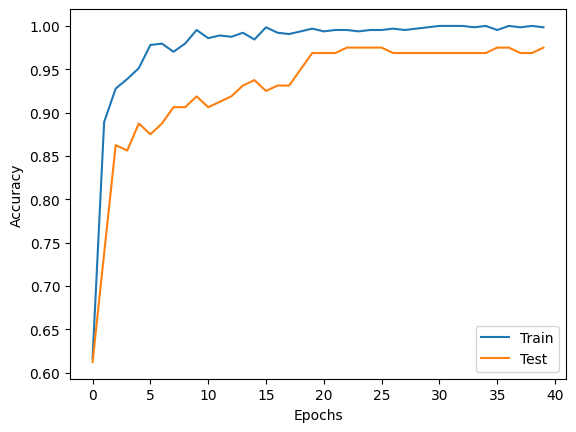

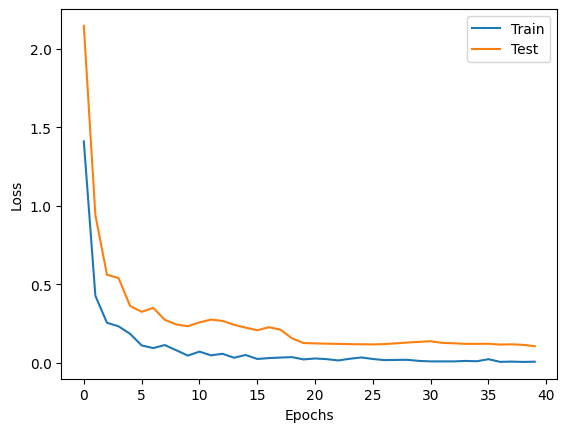

1/1 [==============================] - 6s 6s/step


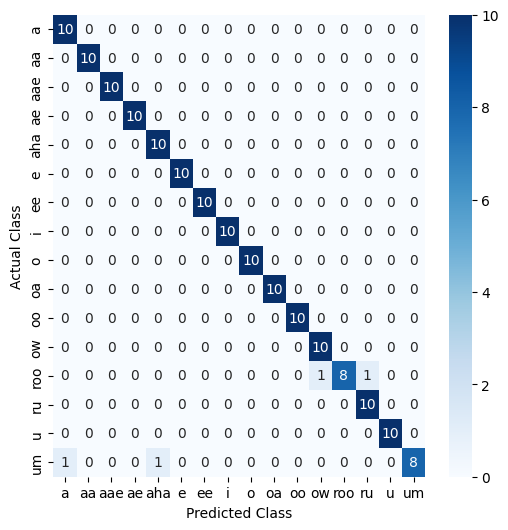

In [ ]:
import logging
logging.getLogger("tensorflow").disabled = True
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.applications.vgg16 import VGG16
# import learning_rate as lr

%matplotlib inline

##############################################################################
# Dataset details
train_data_dir = '/content/drive/MyDrive/Dataset_KHCR/Train'  # Adjust the path accordingly
validation_data_dir = '/content/drive/MyDrive/Dataset_KHCR/valid'  # Adjust the path accordingly
nb_train_samples = 669  # 16 classes * 20 images per class
nb_validation_samples = 160  # 4 classes * 20 images per class
num_classes = 16  # Number of Kannada handwritten characters

def decayed_learning_rate(step):
    if step < 5:
        lr = 0.0001
    else:
        lr = 0.00005
    return lr

def decayed_learning_rate_tuned50(step):
    if step < 5:
        lr = 0.0000001
    elif step < 45:
        lr = 0.000005
    else:
        lr = 0.000001
    return lr

# Learning parameters
epochs1 = 20
epochs2 = 20
learning_rate1 = decayed_learning_rate
learning_rate2 = decayed_learning_rate_tuned50

# Set seeds for reproducibility
np.random.seed(1)
tensorflow.random.set_seed(1)
##############################################################################

batch_size = 32
img_width, img_height = 224, 224  # Adjust the target size based on your requirements
input_shape = (img_width, img_height, 3)  # Adjust input shape based on target size

##############################################################################
# Training Phase - I
source_model = VGG16(include_top=False, input_shape=input_shape)
model = Sequential()
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13
)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical'
)

callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1
)

model.save_weights('/content/drive/MyDrive/Dataset_KHCR/result/HCR-Net-Aug-I.h5')  # Adjust the path accordingly

# Training Phase - II
for layer in model.layers[:12]:
    layer.trainable = True

train_generator.reset()
validation_generator.reset()

model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

callback = tensorflow.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1
)

model.save_weights('/content/drive/MyDrive/Dataset_KHCR/result/HCR-Net-Aug-II.h5')  # Adjust the path accordingly

# Plot the convergence in terms of accuracy and loss
plt.plot(history1.history['accuracy'] + history2.history['accuracy'])
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss'] + history2.history['loss'])
plt.plot(history1.history['val_loss'] + history2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Evaluate model and plot confusion matrix
predict = model.predict(validation_generator)
y_pred = np.argmax(predict, axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(math.ceil(num_classes / 3.0), math.ceil(num_classes / 3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
from IPython.display import Image
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model.load_weights('/content/drive/MyDrive/Dataset_KHCR/result/HCR-Net-Aug-II.h5')  # Adjust the path accordingly

# Function to predict the class of an input image
def predict_image_class(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to match the training data preprocessing

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    return predicted_class

# Upload an image file
uploaded = files.upload()

# Display the uploaded image
img_path = list(uploaded.keys())[0]
Image(img_path)

# Predict the class of the uploaded image
predicted_class = predict_image_class(img_path)

# Display the predicted class
print("Predicted Class:", predicted_class)


Saving img003-019.png to img003-019.png
1/1 [==============================] - 0s 26ms/step
Predicted Class: 5
